In [0]:
import numpy as np
import pandas as pd
from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.optimizers import SGD
import seaborn as sns
import matplotlib.pyplot as plt
ifrom sklearn.metrics import classification_report
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input, Dense, Dropout, Flatten, Activation

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data = pd.read_json("/content/drive/My Drive/kaggle/data/train/train.json")
test=pd.read_json("/content/drive/My Drive/kaggle/data/test/test.json")

In [0]:
X_band_1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in data["band_1"]])
X_band_2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in data["band_2"]])
channel_3 = X_band_1 + X_band_2
new_data = np.concatenate([X_band_1[:, :, :, np.newaxis],
                             X_band_2[:, :, :, np.newaxis],
                             channel_3[:, :, :, np.newaxis]], axis=-1)

targets = data["is_iceberg"]

# split in test and train
split = np.array_split(new_data, 10, axis=0)
X_train = np.concatenate(split[0:8], axis=0)
X_test = np.concatenate(split[8:10], axis=0)
y_train = np.concatenate(np.array_split(targets, 10, axis=0)[0:8], axis=0)
Y_test = np.concatenate(np.array_split(targets, 10, axis=0)[8:10], axis=0)


y_train = np_utils.to_categorical(y_train, num_classes=2)
y_test = np_utils.to_categorical(Y_test, num_classes=2)

In [0]:
gen = ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         width_shift_range=2,
                         height_shift_range=2,
                         channel_shift_range=0,
                         zoom_range=0.2,
                         rotation_range=10)

gen_op = gen.flow(x=X_train, y=y_train, batch_size=10, seed=10)
gen_val = gen.flow(x=X_test, y=y_test, batch_size=10, seed=10)

In [0]:
def getModel():
    base_model = VGG16(weights='imagenet', include_top=False,
                       input_shape=X_train.shape[1:], classes=2)
    x = base_model.get_layer("block5_pool").output
    x = GlobalAveragePooling2D()(x)

    
    x = Dense(512, activation='relu', name="dense1")(x)
    x = Dropout(rate=0.2)(x)
    x = Dense(512, activation="relu", name="dense2")(x)
    x = Dropout(rate=0.3)(x)
    predictions = Dense(2, activation='softmax', name="output")(x)
 
    model = Model(inputs=base_model.input, outputs=predictions)

 
    for layer in base_model.layers:
        layer.trainable = False

    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])

    return model

In [0]:
model = getModel()


# fit the data on model
history = model.fit_generator(generator=gen_op,
                    steps_per_epoch=40,
                    epochs=20,
                    validation_data=gen_val,
                    validation_steps=2)

Epoch 1/15
40/40 [==============================] - 23s 575ms/step - loss: 0.7968 - acc: 0.5700 - val_loss: 0.7624 - val_acc: 0.6000
Epoch 2/15
40/40 [==============================] - 23s 572ms/step - loss: 0.6332 - acc: 0.6775 - val_loss: 0.5697 - val_acc: 0.6500
Epoch 3/15
40/40 [==============================] - 23s 572ms/step - loss: 0.5667 - acc: 0.7075 - val_loss: 0.7613 - val_acc: 0.5000
Epoch 4/15
40/40 [==============================] - 23s 573ms/step - loss: 0.5574 - acc: 0.7187 - val_loss: 0.7462 - val_acc: 0.5500
Epoch 5/15
40/40 [==============================] - 23s 573ms/step - loss: 0.5691 - acc: 0.6875 - val_loss: 0.6146 - val_acc: 0.5000
Epoch 6/15
40/40 [==============================] - 23s 569ms/step - loss: 0.5245 - acc: 0.7150 - val_loss: 0.5452 - val_acc: 0.7500
Epoch 7/15
40/40 [==============================] - 23s 573ms/step - loss: 0.5405 - acc: 0.7025 - val_loss: 0.4036 - val_acc: 0.8500
Epoch 8/15
40/40 [==============================] - 23s 575ms/step - 

In [0]:
#model.load_weights("/content/drive/My Drive/Colab Notebooks/vgg16_weights_tf_dim_ordering_tf_kernels.h5")
val_score = model.evaluate( gen_val, verbose = 1 )
print( 'Validation score: {:.3f}'.format(val_score[0]) )
print( 'Validation accuracy: {:.2f}%'.format(val_score[1]*100) )
print( '='*20, '\n' )

32/32 [==============================] - 18s 554ms/step
Validation score: 0.495
Validation accuracy: 78.44%



In [0]:
train_score = model.evaluate( gen_op, verbose = 1 )
print( 'train score: {:.3f}'.format(val_score[0]) )
print( 'train accuracy: {:.2f}%'.format(val_score[1]*100) )
print( '='*20, '\n' )

129/129 [==============================] - 70s 545ms/step
train score: 0.457
train accuracy: 75.62%



In [0]:
predictions = model.predict(X_test, batch_size=10)
y_pred = np.argmax(predictions, axis=1)

In [0]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.81      0.81       211
           1       0.64      0.66      0.65       109

    accuracy                           0.76       320
   macro avg       0.73      0.73      0.73       320
weighted avg       0.76      0.76      0.76       320



In [0]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(Y_test, y_pred)

(array([0.82125604, 0.63716814]),
 array([0.8056872 , 0.66055046]),
 array([0.81339713, 0.64864865]),
 array([211, 109]))

In [0]:
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix

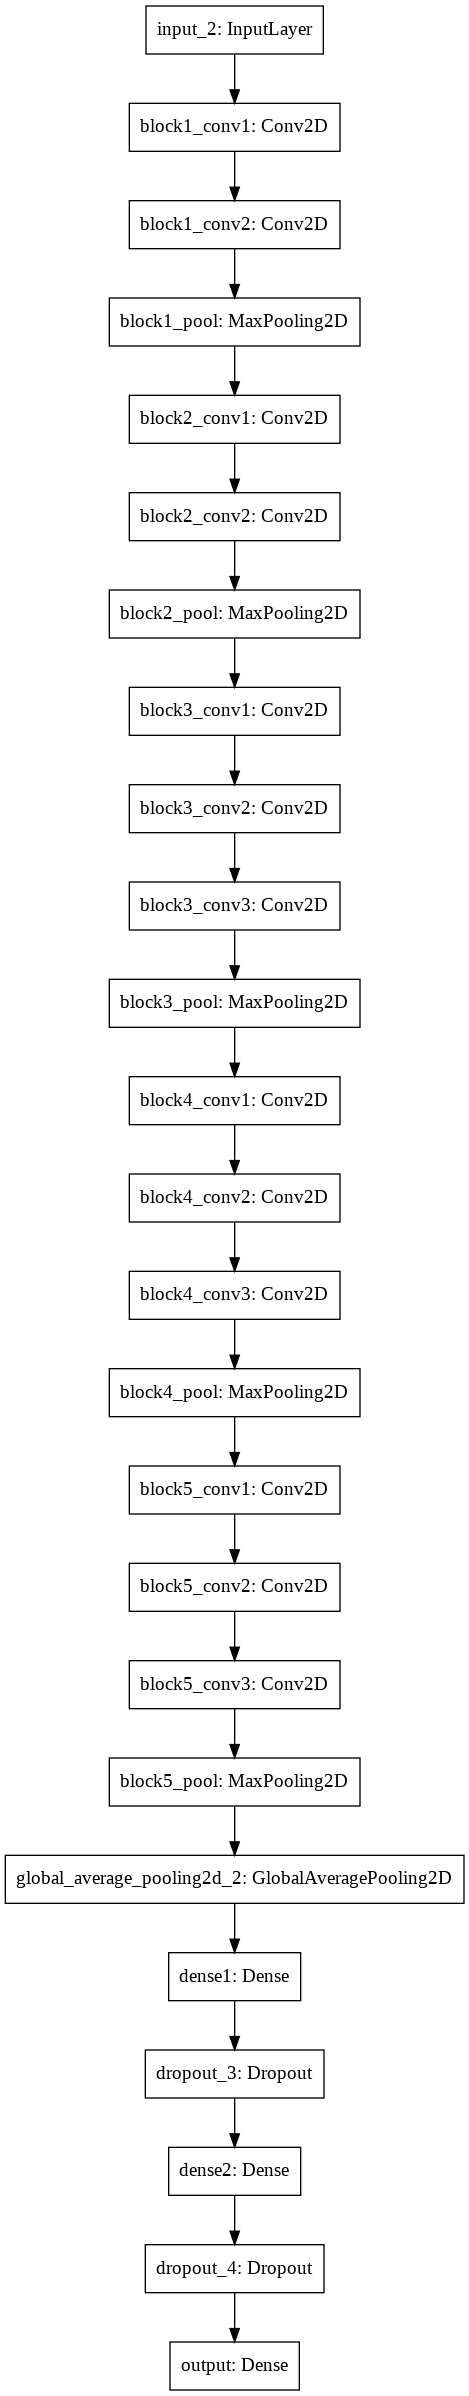

In [0]:
plot_model(model)

In [0]:
confusion_matrix(Y_test,y_pred)

array([[170,  41],
       [ 37,  72]])

In [0]:
predictions = model.predict(X_test, batch_size=10)
y_pred = np.argmax(predictions, axis=1)

In [0]:
def plot_history(history):
    # history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    # history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
def plot_confusion_matrix(y_test, y_pred):
    cnf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(cnf_matrix, square=True, cmap='RdYlGn')
    plt.show()

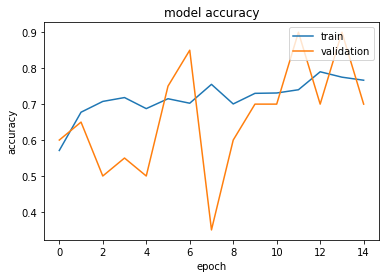

In [0]:
plot_history(history)

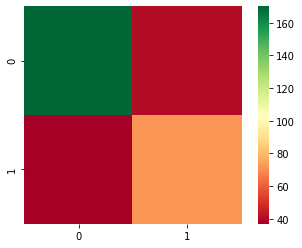

In [0]:
plot_confusion_matrix(Y_test,y_pred)

In [0]:
confusion_matrix(Y_test,y_pred)

array([[170,  41],
       [ 37,  72]])